In [1]:
#https://bab2min.github.io/tomotopy/v0.12.3/kr/#tomotopy.LDAModel
# Package Load
import pickle
import pyLDAvis
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import tomotopy as tp
import tomotopy.coherence as tpc
from gensim.corpora import Dictionary
from datetime import datetime
from tqdm import tqdm
from datetime import datetime
from timeit import default_timer
import plotly.express as px
import plotly.offline
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
#os.chdir("C:\\Users\\newcomer02\\NTIS_Project")

## 코퍼스 파일 로드
### 아무것도 입력하지 않고 엔터만 누를 시 디폴트 파일 Load

In [53]:
topic_ver = str(input("분석하고 싶은 토픽의 번호를 입력하시오:"))
DATA_DIR = "./data/LDA/NTIS/corpus_topic/"

분석하고 싶은 토픽의 번호를 입력하시오:11


In [54]:
corpus=[]
for n, line in tqdm(enumerate(open(DATA_DIR + "LDA_topic_"+topic_ver+".txt", encoding='CP949'))):
    doc=line.strip().split()
    corpus.append(doc)

480it [00:00, 30081.52it/s]


In [55]:
sct = sum(corpus,[])
from collections import Counter

In [56]:
df_sct = pd.DataFrame(Counter(sct).most_common(),columns=["word","count"])

In [57]:
mcf = df_sct.iloc[:int(len(df_sct)*  0.2),:]["count"].iloc[-1]-1
mcf

17

## LDA 모델 최적화

In [58]:
upper_topic_num = int(input("LDA 모델 최적 토픽 수를 검증하기 위한 최대 토픽 수를 입력하세요. (※ 10이상의 자연수, 권장값 = 250개)"))
iteration = int(input("학습 Iteration 수를 입력하세요. (※ 100이상의 자연수, 권장값 = 1000회)"))

print('\n 최대 토픽 갯수 %s개로 %d회씩 학습을 진행합니다.'%(upper_topic_num,iteration))

LDA 모델 최적 토픽 수를 검증하기 위한 최대 토픽 수를 입력하세요. (※ 10이상의 자연수, 권장값 = 250개)150
학습 Iteration 수를 입력하세요. (※ 100이상의 자연수, 권장값 = 1000회)1000

 최대 토픽 갯수 150개로 1000회씩 학습을 진행합니다.


## LDA 모델에서 토픽 수를 10, 20, 30 ... 으로 10개씩 증가시키면서 
## 앞에서 입력된 최대 토픽 수까지 모델을 훈련시켜 최적 토픽수를 찾음
### cf. 정해진 토픽수는 없으며, 분석가의 판단에 따라 결정하는 것임

In [59]:
score_u_list=[]
score_c_list=[]
perplexity_list=[]
for opt_tp in tqdm(range(5, upper_topic_num+5, 5)): 
    model=tp.LDAModel(k=opt_tp, min_cf=mcf, rm_top=64 ,tw=tp.TermWeight.PMI, seed=42)
    for cnt in range(len(corpus)):
        model.add_doc(corpus[cnt])
    model.train(iter=iteration, workers=0)
    perplexity_list.append(math.log10(model.perplexity))
    coherence_u=tpc.Coherence(model, coherence='u_mass')
    coherence_c=tpc.Coherence(model, coherence='c_v')
    score_u=coherence_u.get_score()
    score_u_list.append(score_u)
    score_c=coherence_c.get_score()
    score_c_list.append(score_c)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:04<00:00,  4.16s/it]


## (1) Coherence graph : 토픽들이 얼마나 일관성 있는지에 대한 판단 지표
## 수치가 0에 가까울수록 일관성에 대한 해석이 용이

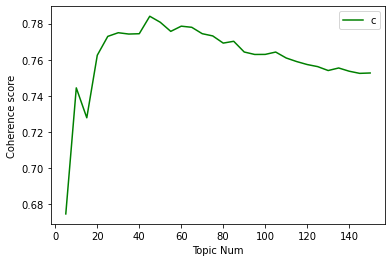

In [61]:
x=range(5, upper_topic_num+5, 5)
plt.plot(x, score_c_list, color='green') 
plt.xlabel("Topic Num") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.show()

In [62]:
print(max(score_c_list))
max_index = score_c_list.index(max(score_c_list)) +1 
max_index

0.7841150423553255


9

In [46]:
score_c_list.index(max(score_c_list[15:25]))

16

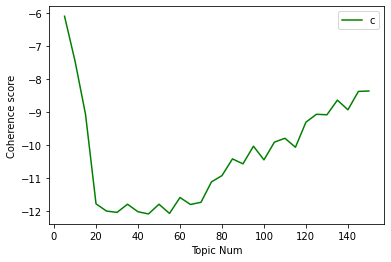

In [47]:
x=range(5, upper_topic_num+5, 5)
plt.plot(x, score_u_list, color='green') 
plt.xlabel("Topic Num") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.show()

## (2) Perplexity 그래프 : 확률 모델이 얼마나 잘 예측하는지에 대한 판단 지표
### 수치가 낮을수록 잘 예측한다고 해석 할 수 있지만, 이는 사람이 해석하는데 용이하다는 것을 의미하는 것은 아님

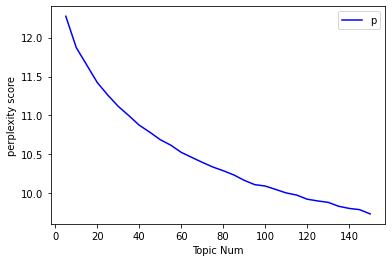

In [29]:
x=range(5, upper_topic_num+5, 5)
plt.plot(x, perplexity_list, color='blue') 
plt.xlabel("Topic Num") 
plt.ylabel("perplexity score") 
plt.legend(("perplexity_values"), loc='best') 
plt.show()

In [63]:
score_u_list_2=[]
score_c_list_2=[]
perplexity_list_2=[]
for opt_tp in tqdm(range(max_index*5-5, max_index*5+5, 1)): 
    model=tp.LDAModel(k=opt_tp, min_cf=mcf, rm_top=64 ,tw=tp.TermWeight.PMI, seed=42)
    for cnt in range(len(corpus)):
        model.add_doc(corpus[cnt])
    model.train(iter=iteration, workers=0)
    perplexity_list_2.append(math.log10(model.perplexity))
    coherence_u_2=tpc.Coherence(model, coherence='u_mass')
    coherence_c_2=tpc.Coherence(model, coherence='c_v')
    score_u_2=coherence_u_2.get_score()
    score_u_list_2.append(score_u_2)
    score_c_2=coherence_c_2.get_score()
    score_c_list_2.append(score_c_2)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.91s/it]


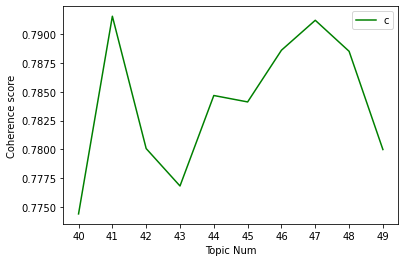

In [64]:
x=range(max_index*5-5, max_index*5+5, 1)
plt.plot(x, score_c_list_2, color='green') 
plt.xlabel("Topic Num") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
#plt.axvline(x=23,color='r')
plt.xticks(np.arange(max_index*5-5, max_index*5+5))
plt.show()

In [66]:
score_c_list_2

[0.7744089074432849,
 0.7915409935683739,
 0.7800717088438215,
 0.7768307781496714,
 0.7846718350594696,
 0.7841150423553255,
 0.7885967443818632,
 0.7911913021447811,
 0.7885038578882814,
 0.7799880269838838]

In [65]:
print(score_c_list[0:20].index(max(score_c_list[0:20])))

8


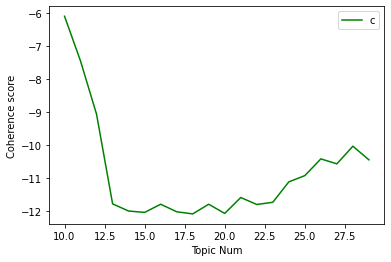

In [51]:
x=range(10, 30, 1)
plt.plot(x, score_u_list[0:20], color='green') 
plt.xlabel("Topic Num") 
plt.ylabel("Coherence score") 
plt.legend(("coherence_values"), loc='best') 
plt.show()

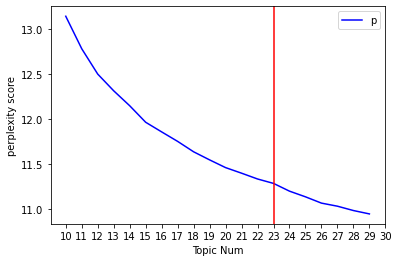

In [52]:
x=range(10, 30, 1)
plt.plot(x, perplexity_list[0:20], color='blue') 
plt.xlabel("Topic Num") 
plt.ylabel("perplexity score") 
plt.legend(("perplexity_values"), loc='best')
#plt.axvline(x=23,color='r')
plt.xticks(np.arange(10,31))
plt.show()